In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt


import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.animation as animation
from IPython.display import HTML


import warnings; warnings.simplefilter('ignore')

In [2]:
# Coordinates for large regions. Position in
# (lon, lat): (rigth,  letf), (south, north),
# and title for an eventual ploting title.
reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    },
    'nor':{
        'lon' : (-40, 40.),
        'lat' : (65, 85),
        'name' : 'North Atlantic Ocean'
    },
    'noa':{
        'lon' : (-90, 15.),
        'lat' : (10, 85),
        'name' : 'North Atlantic Ocean'
    }
}

In [3]:
## Function to crop the dataset
def Crops(coord, d_set, dictionary):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by a dictionary.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
            
        dictionary: dic
            name of the dictionary wwith the coordinates
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """

    lon1, lon2 = dictionary[coord]['lon']
    lat1, lat2 = dictionary[coord]['lat']
    name_fig = dictionary[coord]['name']

    return(d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2)))



def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)
    
    
def Masking(data_set, cond):
    """
        Maskin is a function that makes a mask of an array depending on the 
        entering condition. The condition is evaluated over finite numbers.
        At the final, the mask is appended in the original DataArray as a 
        new coordinate.
        
        Parameters:
        ------------
        data_set : DataArray
            Is the array we want to make the mask of.
            
        cond : array
            Codition to meet. 


        Output:
        -------
        data_set : Numpy Arrray
            Array with new coordinates 'mask'
    """
    
    mask = 1 * np.ones((data_set.dims['latitude'], data_set.dims['longitude'])) * np.isfinite(cond)  
    data_set.coords['mask'] = (('latitude', 'longitude'), mask)
    return(data_set)



def Map(ax, region, xtick, ytick):
    """
        Map is a function that helps to plot the map on a certain projection
        of a region. It always uses 50m definition of coastlines.

        Parameters:
        ------------
        ax : axes
            Current axes object in which is drawn the map.

        region : list
            Set of limit coordinates of the region to plot.
            It has the shape [lon1, lon2, lat1, lat2]

        xtick : np.array
            array containing the number and spacement of ticks 
            in x-axis.

        ytick : np.array
            Array containing the number and spacement of ticks 
            in y-axis.
    """
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtick, crs=ccrs.PlateCarree())
    ax.set_yticks(ytick, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')


def Limits(data_set):
    
    mn = data_set.min(skipna=True).values
    mx = data_set.max(skipna=True).values
    return(mn, mx)


def Normalize(data_set):
    mn = data_set.min(dim='week', skipna=True)
    mx = data_set.max(dim='week', skipna=True)
    
    y = (data_set - mn) / (mx - mn)
    return y


def Re_arrange(data_set, years):
    g = []

    for i,y in enumerate(years):
        aa = points.sel(time=points.time.dt.year==y)
        aa = aa.groupby('time.week').mean(dim='time', skipna=True)

        aa = aa.sel(week=slice(1,52))
        g.append(aa)
        del aa

    return(g)



def Shift(data_set):
    max_w = data_set.groupby('point').argmax(dim='week', keep_attrs=True, skipna=True).values
    r = 26 - max_w 
    
    data = data_set.T.values
    del data_set
    
    rows, column_indices = np.ogrid[:data.shape[0], :data.shape[1]]
    r[r < 0] += data.shape[1]
    column_indices = column_indices - r[:, np.newaxis]
    shft = data[rows, column_indices]
    shift = xr.DataArray(shft.T, dims=['week', 'point'], name='mlotst')

    return(shift)

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################
dir_1 = '../../Other_datasets/'
dir_o = '/home/lgarcia/Documents/Scripts/dummy_images/'

fl_n1 = 'PCA_projections.nc'

EOF = xr.open_mfdataset(dir_1 + fl_n1)

# The animation

In [5]:
## List of years to plot

years = [y for y in range(2005, 2018)]

In [12]:
mini = EOF.reduced_data.min(skipna=True).values
maxi = EOF.reduced_data.max(skipna=True).values

print(mini, maxi)

-408.4447415300739 909.8610827815726


In [21]:
## Parameters for the plot. Colormap, number of intervals
## colorbar's name, the title of the figure and the name 
## to save the figure. Also the coordinate to plot.

cb_label = 'PC'    # Label for colorbar
cmap = 'seismic'#'RdBu_r'
levels = np.linspace(-900, 900, 55)

save_name = "Gul-PC"
fig_tit = 'Gulf Stream PC'

coord = 'gul'

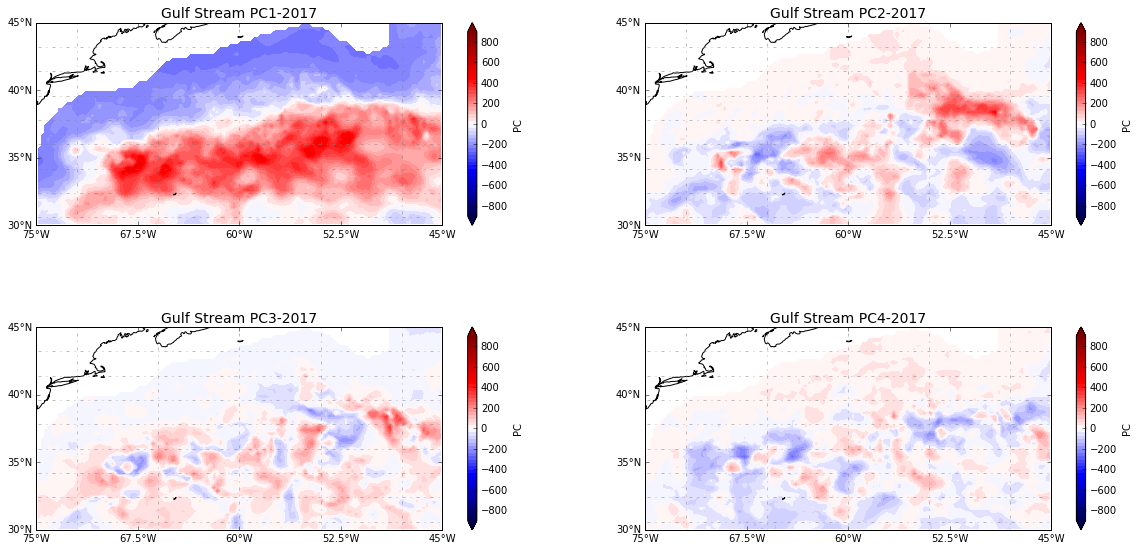

In [23]:
## Plot the 4 first Principal components in the same figure
## for each year and save them with correlative names.
## The process is inside a loop over the years.


for y,year in enumerate(years):

    %matplotlib inline

    plt.close()

    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat

    xtick = np.linspace(lon1, lon2, num=5)
    ytick = np.linspace(lat1, lat2, num=4)

    x_n, y_n = Grid(EOF)
    projection = ccrs.PlateCarree(360)
    
    fig, ax = plt.subplots(nrows=2, ncols=2, subplot_kw=dict(projection=projection), 
                            figsize=(20,10)) 
    pc = 0
    
    for i in range(2):
        for j in range(2):
            # Variables to plot
            mapping_var = EOF.reduced_data[y,pc]  # In the colormap

            Map(ax[i,j], region, xtick, ytick)

            contr1 = ax[i,j].contourf(x_n, y_n, mapping_var, levels=levels, cmap=cmap, extend='both')
            cbar = fig.colorbar(contr1, ax=ax[i,j], shrink=0.8, orientation='vertical',
                                label=cb_label) 
            
            ## Title for the figure
            fig_title = fig_tit + str(pc+1) + '-' + str(year)
            ax[i,j].set_title(fig_title, fontsize=14)

            pc += 1

    plt.savefig(dir_o + save_name + "-%0.4d.png" %y)
    
    #plt.show()

### Line to create the animation

In [ ]:
##ffmpeg -r 2 -f image2 -s 1920x1080 -i dummy_images/Gul-PC-%04d.png -vcodec libx264 -crf 25  -pix_fmt yuv420p /home/lgarcia/Documents/Scripts/Animations/Gul-PC.mp4 -vf "pad=ceil(iw/2)*2:ceil(ih/2)*2"
